# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [0]:
(train_data,_),(test_data,_) = mnist.load_data()

In [0]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [17]:
data.shape

(70000, 28, 28)

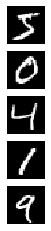

In [18]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [0]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [20]:
# NOT Flattening of the image vectors!!!!
# This is a convolutional model, so it works well with 2D data
# data = data.reshape(data.shape[0],-1)

# Instead, we add a new "channel" axis to the data. 
# Since this is grayscale, that is only 1 channel.

data = data[:,np.newaxis]

data.shape

(70000, 28, 28, 1)

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [0]:
EPOCHS = 100
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters


Please remember:

<img src="https://miro.medium.com/max/760/1*B7y91tLgeWE-EuuFP-1XwA.png" width=65%>

And:

<img src="https://qph.fs.quoracdn.net/main-qimg-d4023fe66cac95238a76ea1b5bc21d84" wudth=45%>

In [0]:
GENERATOR_INITIAL_IMAGE_SIZE = 7
GENERATOR_INITIAL_IMAGE_CHANNELS = 128
GENERATOR_L1_DIM = GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_CHANNELS 
# eg. 7*7 image, 128 channels it will be, and we go DOWN with the channels from there

# We have to take care, that the final shape of all generator convolutions results in 28*28*1, 
# so it is a kind of balancing act
GENERATOR_L2_DIM = 64
GENERATOR_L2_KERNEL_SIZE = (5,5)
GENERATOR_OUTPUT_DIM = 1 # Number of output CHANNELS!!!!
GENERATOR_OUTPUT_KERNEL_SIZE = (5,5)

GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 64
DISCRIMINATOR_L1_KERNEL_SIZE = (5,5)
DISCRIMINATOR_L2_DIM = 128
DISCRIMINATOR_L2_KERNEL_SIZE = (5,5)

LEAKY_ALPHA = 0.2

## Model building

In [0]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Conv2D, Flatten, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model

In [0]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM,))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)

# But we do have to ensure that the input for anything convolutional is 2D + channel, so reshape is in order
# remeber, it is image szie * image size * channels
# ant this is the initial "image"
# USE THE DEFINED CONSTANTS FROM ABOVE, and define a reshape layer!
reshaped_layer = Reshape((GENERATOR_INITIAL_IMAGE_SIZE,GENERATOR_INITIAL_IMAGE_SIZE,GENERATOR_INITIAL_IMAGE_CHANNELS))(g_layer_1)

# Define a non-linearity, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(LEAKY_ALPHA)(reshaped_layer)

# For stability, we add a batch normalization layer - no extra settings.
g_layer_1_batchnorm = BatchNormalization()(g_layer_1_nonlin)

# Now we use Upsampling to gradually get the image resolution up, by doubling
# upsampling layer does this without any extra parameters.
g_layer_2_upsample = UpSampling2D()(g_layer_1_batchnorm)
# As a result we have 14*14*128 - with the above default settings

# Furthermore we use convolutions to get the number of channels down
# Define a convolutional layer to get down to the layer 2 dimension of generator (number of filters)
# Use the defined constant from above for layer 2 kernel size, and use _"same"_ padding
g_layer_2_conv = Conv2D(GENERATOR_L2_DIM, kernel_size=GENERATOR_L2_KERNEL_SIZE, padding="same")(g_layer_2_upsample)
# As a result we get 14*14*64 - with the above default settings

# And again a non linearity as above, please...
g_layer_2_nonlin = LeakyReLU(LEAKY_ALPHA)(g_layer_2_conv)
# And a batch normalization, as above, please...
g_layer_2_batchnorm = BatchNormalization()(g_layer_2_nonlin)

# Now we again use Upsampling to gradually get the image resolution up, by doubling
g_layer_3_upsample = UpSampling2D()(g_layer_2_batchnorm)
# As a result we have 28*28*64 - with the above default settings

# Furthermore we use Conv2D to get the number of channels down
# Define a convolutional layer to get down to the output layer dimension of generator (number of filters)
# Use the defined constant from above for output layer kernel size, and use _"same"_ padding
# USE A NON-LINEARITY TO PROJECT BETWEEN -1 and 1!!! 
# Remember, the images are normalized!
g_output_layer = Conv2D(GENERATOR_OUTPUT_DIM, kernel_size=GENERATOR_OUTPUT_KERNEL_SIZE, padding="same", activation = 'tanh')(g_layer_3_upsample)
# As a result we get 28*28*1 - with the above default settings
# And please notice, that we used an activation, so our pixels get between -1 and 1 again
# This should now be indistinguishable from an input image - hopefully

# Please instantiate the model!
generator = Model(noise_input,g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [37]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets original sized images, so 28x28x1 (channel) as inputs
image_input = Input(shape=(data.shape[1:]))

# Define the first convolutional layer of the discriminator!
# Use the above defined constants for  filter number and kernel size!
# We use strides of 2,2 instead of pooling, which is a sparse operator, and _"same"_ padding
d_layer_1 = Conv2D(filters=DISCRIMINATOR_L1_DIM, kernel_size=DISCRIMINATOR_L1_KERNEL_SIZE, padding="same", strides= (2,2))(image_input)
# And add a non-linearity, as in the discriminator, please...
d_layer_1_nonlin = LeakyReLU(LEAKY_ALPHA)(d_layer_1)

# Repet the block again, please!
d_layer_2 = Conv2D(filters=DISCRIMINATOR_L2_DIM, kernel_size=DISCRIMINATOR_L2_KERNEL_SIZE, padding="same")(image_input)
d_layer_2_nonlin = LeakyReLU(LEAKY_ALPHA)(d_layer_2)

# Please use an appropriate operation 
# to make the output of the previos conv compatible with a fully connected layer!
d_layer_2_flattened = Flatten()(d_layer_2_nonlin)

# Please implement the output layer!
# The output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_flattened)

# Please instantiate the model!
discriminator = Model(image_input,d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Joint model

In [0]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=(Z_DIM,))

# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(gan_input,gan_output)

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)
# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [0]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("DCGAN_example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "DCGAN_example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

In [41]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = data[np.random.choice(data.shape[0],HALF_BATCH,replace=False)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0,1,size=(HALF_BATCH,Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
   
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones((HALF_BATCH,1)) * 0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros((HALF_BATCH,1))

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0,1,size=[BATCH_SIZE,Z_DIM])
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worth of one dimensional matrix filled with ones 
        convincing_y = np.ones(BATCH_SIZE)
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

Output hidden; open in https://colab.research.google.com to view.

## Visualization of training progress

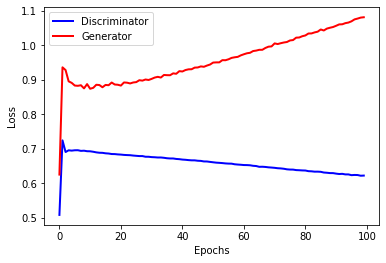

In [42]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
